<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 4: Implementing a GPT model from Scratch To Generate Text 

In [1]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.9.0
torch version: 2.4.0
tiktoken version: 0.7.0


- In this chapter, we implement a GPT-like LLM architecture; the next chapter will focus on training this LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">

## 4.1 Coding an LLM architecture

- Chapter 1 discussed models like GPT and Llama, which generate words sequentially and are based on the decoder part of the original transformer architecture
- Therefore, these LLMs are often referred to as "decoder-like" LLMs
- Compared to conventional deep learning models, LLMs are larger, mainly due to their vast number of parameters, not the amount of code
- We'll see that many elements are repeated in an LLM's architecture

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">

- In previous chapters, we used small embedding dimensions for token inputs and outputs for ease of illustration, ensuring they fit on a single page
- In this chapter, we consider embedding and model sizes akin to a small GPT-2 model
- We'll specifically code the architecture of the smallest GPT-2 model (124 million parameters), as outlined in Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) (note that the initial report lists it as 117M parameters, but this was later corrected in the model weight repository)
- Chapter 6 will show how to load pretrained weights into our implementation, which will be compatible with model sizes of 345, 762, and 1542 million parameters

- Configuration details for the 124 million parameter GPT-2 model include:

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- We use short variable names to avoid long lines of code later
- `"vocab_size"` indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer discussed in Chapter 2
- `"context_length"` represents the model's maximum input token count, as enabled by positional embeddings covered in Chapter 2
- `"emb_dim"` is the embedding size for token inputs, converting each input token into a 768-dimensional vector
- `"n_heads"` is the number of attention heads in the multi-head attention mechanism implemented in Chapter 3
- `"n_layers"` is the number of transformer blocks within the model, which we'll implement in upcoming sections
- `"drop_rate"` is the dropout mechanism's intensity, discussed in Chapter 3; 0.1 means dropping 10% of hidden units during training to mitigate overfitting
- `"qkv_bias"` decides if the `Linear` layers in the multi-head attention mechanism (from Chapter 3) should include a bias vector when computing query (Q), key (K), and value (V) tensors; we'll disable this option, which is standard practice in modern LLMs; however, we'll revisit this later when loading pretrained GPT-2 weights from OpenAI into our reimplementation in chapter 5

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="500px">

In [3]:
import torch
import torch.nn as nn
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        """
        构造函数，用于初始化DummyGPTModel类的实例
        :param cfg: 配置字典，包含模型的各种参数设置，如词汇表大小、嵌入维度、上下文长度、Dropout概率、Transformer块数量等
        """
        super().__init__()
        # 创建词嵌入层，将输入的词汇索引转换为对应的词向量
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # 词汇表大小，即模型能处理的不同词汇的数量
        # 词向量的维度，决定了每个词向量的特征表示长度
        # 创建位置嵌入层，为输入序列中的每个位置添加位置信息
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # 模型能处理的输入序列的最大长度
        # 与词向量维度相同，以便能与词向量相加
        # 创建Dropout层，用于在训练过程中随机丢弃一些神经元的输出，防止过拟合
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        # Dropout概率，指定了每个元素被丢弃的概率
        # 使用占位符创建Transformer块序列，目前这些块只是简单占位，实际功能未实现
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        # 循环创建指定数量（由cfg["n_layers"]指定）的DummyTransformerBlock实例，并组合成序列
        # 每个DummyTransformerBlock目前只是一个简单占位符，后续需完善其功能以实现真正的Transformer块操作
        # 使用占位符创建层归一化模块，目前只是简单占位，实际功能未实现
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        # 用于在模型最后对输入进行层归一化处理，虽目前只是占位，但完整模型中可提高训练稳定性和性能
        # 创建线性输出层，将经过前面处理后的向量转换为与词汇表大小相同维度的向量，用于预测下一个词汇的概率分布
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        # 输入维度为cfg["emb_dim"]，输出维度为cfg["vocab_si
    def forward(self, in_idx):
        """
        前向传播函数，定义数据在模型中的流动和计算过程
        :param in_idx: 输入的词汇索引张量，形状为(batch_size, seq_len)，batch_size是批处理大小，seq_len是序列长度
        :return: 预测得到的下一个词汇的概率分布向量，用于后续计算损失、评估模型等操作
        """
        batch_size, seq_len = in_idx.shape
        # 通过词嵌入层将输入的词汇索引转换为对应的词向量
        tok_embeds = self.tok_emb(in_idx)
        # 通过位置嵌入层为输入序列中的每个位置生成位置向量
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # 将词向量和位置向量相加，得到包含词汇信息和位置信息的综合向量
        x = tok_embeds + pos_embeds
        # 对综合向量进行Dropout操作，随机丢弃一些神经元的输出
        x = self.drop_emb(x)
        # 将向量传入由多个DummyTransformerBlock组成的序列模块中进行处理，目前只是简单传递输入
        x = self.trf_blocks(x)
        # 将经过DummyTransformerBlock处理后的向量传入DummyLayerNorm实例进行层归一化操作，目前也是简单传递输入
        x = self.final_norm(x)
        # 将经过前面一系列处理后的向量传入线性输出层，转换为与词汇表大小相同维度的向量
        logits = self.out_head(x)
        return logits
# 定义一个简单的占位符类，用于表示Transformer块，目前该类的功能未实现，只是简单返回输入
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        """
        构造函数，用于初始化DummyTransformerBlock类的实例
        :param cfg: 配置字典，包含模型的各种参数设置，虽然目前该类未使用这些参数，但完整实现时可能会用到
        """
        super().__init__()
    def forward(self, x):

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="500px">

In [4]:
import tiktoken
import torch
# 获取tiktoken库中名为"gpt2"的编码方式对应的编码器
tokenizer = tiktoken.get_encoding("gpt2")
# 创建一个空列表，用于存储后续经过编码并转换为张量的文本数据
batch = []
# 定义第一段文本内容
txt1 = "Every effort moves you"
# 定义第二段文本内容
txt2 = "Every day holds a"
# 使用tokenizer对第一段文本txt1进行编码，将文本转换为对应的编码序列（通常是整数序列）
# 然后将编码后的序列转换为PyTorch的张量，并添加到batch列表中
batch.append(torch.tensor(tokenizer.encode(txt1)))
# 使用tokenizer对第二段文本txt2进行编码，同样将编码后的序列转换为张量，并添加到batch列表中
batch.append(torch.tensor(tokenizer.encode(txt2)))
# 将batch列表中的张量沿着指定维度dim=0进行堆叠操作
# 这样就将两个单独的文本张量组合成了一个批量的张量，方便后续进行批量处理（比如同时输入到模型中进行处理等）
batch = torch.stack(batch, dim=0)
# 打印出经过堆叠操作后的batch张量，查看其具体内容和形状等信息
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
# 创建DummyGPTModel类的实例，传入GPT_CONFIG_124M配置字典作为参数
model = DummyGPTModel(GPT_CONFIG_124M)
# 将之前准备好的batch张量（它是经过编码和堆叠后的文本数据张量）传入model的前向传播函数中
# 模型会根据其内部定义的计算逻辑（包括词嵌入、位置嵌入、可能的Transformer块处理、层归一化以及输出层等操作，虽然部分是占位符）对输入数据进行处理，并返回预测得到的下一个词汇的概率分布向量
logits = model(batch)
# 打印出预测结果logits的形状，通常其形状为(batch_size, vocab_size)
# 其中batch_size是输入数据的批处理大小，vocab_size是模型的词汇表大小
# 这个形状表示了对于每个输入文本在batch中的每个位置，模型预测出的下一个词汇是词汇表中每个词汇的概率分布情况
print("Output shape:", logits.shape)
# 打印出预测结果logits的具体内容，即具体的概率值矩阵
# 每一行对应一个输入文本在batch中的情况，每一列对应词汇表中的一个词汇，矩阵中的值表示相应的概率
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


---

**Note**

- If you are running this code on Windows or Linux, the resulting values above may look like as follows:
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- Since these are just random numbers, this is not a reason for concern, and you can proceed with the remainder of the chapter without issues

---

## 4.2 Normalizing activations with layer normalization

- Layer normalization, also known as LayerNorm ([Ba et al. 2016](https://arxiv.org/abs/1607.06450)), centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1
- This stabilizes training and enables faster convergence to effective weights
- Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later; it's also applied before the final output layer

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="400px">

- Let's see how layer normalization works by passing a small input sample through a simple neural network layer:

In [6]:
torch.manual_seed(123)
# 创建2个训练示例，每个示例具有5个维度（特征）
# torch.randn函数用于生成服从标准正态分布的随机张量。这里生成的张量形状为(2, 5)，表示有2个样本，每个样本有5个特征维度。
batch_example = torch.randn(2, 5) 
# 创建一个Sequential序列容器，其中包含两个神经网络层：
# 第一个是线性层nn.Linear(5, 6)，它将输入的5维特征向量映射为6维的输出向量。
# 第二个是ReLU激活函数层nn.ReLU()，它会对线性层的输出进行非线性变换，将小于0的值变为0，大于等于0的值保持不变。
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
# 将生成的训练示例batch_example传入创建好的神经网络层序列layer中进行前向传播计算。
# 数据会先经过线性层进行线性变换，然后再经过ReLU激活函数层进行非线性变换，最终得到输出结果out。
out = layer(batch_example)
# 打印出经过神经网络层处理后的输出结果out，以便查看具体的计算结果。
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- Let's compute the mean and variance for each of the 2 inputs above:

In [7]:
mean = out.mean(dim=-1, keepdim=True)
# 计算输出结果out在最后一个维度（dim=-1）上的方差，并保持维度不变（keepdim=True）
# 同样是对每个样本分别计算其在最后一个维度上的方差
# 方差是用来衡量一组数据的离散程度的统计量，这里通过计算每个样本在6维输出向量的每个维度上的方差，来了解数据在各个维度上的分布情况
# 计算得到的方差结果var的形状也会保持与原输出结果out相同的维度结构，只是在最后一个维度上变为1，比如若out的形状是(2, 6)，则var的形状就是(2, 1)
var = out.var(dim=-1, keepdim=True)
# 打印出计算得到的均值结果，以便查看每个样本在最后一个维度上的平均情况
print("Mean:\n", mean)
# 打印出计算得到的方差结果，以便查看每个样本在最后一个维度上的方差情况，从而了解数据在各个维度上的离散程度
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- The normalization is applied to each of the two inputs (rows) independently; using dim=-1 applies the calculation across the last dimension (in this case, the feature dimension) instead of the row dimension

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="400px">

- Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension:

In [8]:
import torch
import torch.nn as nn
torch.manual_seed(123)
# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
# 对经过神经网络层处理后的输出结果out进行归一化操作
# 首先将out减去其在最后一个维度上的均值mean，实现数据在均值上的中心化
# 然后再除以torch.sqrt(var)，即方差var的平方根，使得数据在每个维度上的标准差变为1
# 这样就完成了对输出结果out的归一化处理，得到归一化后的输出out_norm
# 归一化操作有助于提高模型的训练稳定性和收敛速度等，使得不同维度的数据具有相似的尺度，减少数据分布差异对模型训练的影响
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)
# 再次计算归一化后输出out_norm在最后一个维度（dim=-1）上的均值，并保持维度不变（keepdim=True）
# 目的是查看经过归一化操作后，数据在新的分布下每个样本在最后一个维度上的平均情况
mean = out_norm.mean(dim=-1, keepdim=True)
print("Mean:\n", mean)
# 再次计算归一化后输出out_norm在最后一个维度（dim=-1）上的方差，并保持维度不变（keepdim=True）
# 目的是查看经过归一化操作后，数据在新的分布下每个样本在最后一个维度上的方差情况，以了解归一化对数据离散程度的影响
var = out_norm.var(dim=-1, keepdim=True)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Each input is centered at 0 and has a unit variance of 1; to improve readability, we can disable PyTorch's scientific notation:

In [9]:
# 设置PyTorch的打印选项，将科学计数法模式设置为False
torch.set_printoptions(sci_mode=False)
# 打印计算得到的均值
print("Mean:\n", mean)
# 打印计算得到的方差
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Above, we normalized the features of each input
- Now, using the same idea, we can implement a `LayerNorm` class:

In [10]:
import torch
import torch.nn as nn
# 定义一个名为LayerNorm的类，它继承自nn.Module，用于实现层归一化操作
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        """
        类的初始化方法
        Args:
            emb_dim (int): 嵌入维度的大小，用于确定需要初始化的参数维度
        """
        super().__init__()
        # 一个很小的数，用于防止在计算方差时出现除以零的情况，增加数值稳定性
        self.eps = 1e-5
        # 定义可学习的缩放参数，形状为(emb_dim,)，初始化为全1的张量，并且会在训练过程中自动更新
        self.scale = nn.Parameter(torch.ones(emb_dim))
        # 定义可学习的偏移参数，形状为(emb_dim,)，初始化为全0的张量，并且会在训练过程中自动更新
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        """
        前向传播方法，用于执行层归一化的计算
        Args:
            x (torch.Tensor): 输入的张量，形状通常为(batch_size, sequence_length, emb_dim) 等
        Returns:
            torch.Tensor: 经过层归一化和缩放、偏移调整后的输出张量
        """
        # 计算输入张量x在最后一个维度上的均值，keepdim=True表示保持维度不变，以便后续的广播操作
        mean = x.mean(dim=-1, keepdim=True)
        # 计算输入张量x在最后一个维度上的方差，unbiased=False表示使用有偏估计的方差计算方式，keepdim=True同样是为了保持维度不变
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        # 进行归一化操作，将x减去均值后除以方差加eps的平方根，得到归一化后的张量norm_x
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        # 将归一化后的张量norm_x乘以可学习的缩放参数self.scale，再加上可学习的偏移参数self.shift，得到最终的输出
        return self.scale * norm_x + self.shift

**Scale and shift**

- Note that in addition to performing the normalization by subtracting the mean and dividing by the variance, we added two trainable parameters, a `scale` and a `shift` parameter
- The initial `scale` (multiplying by 1) and `shift` (adding 0) values don't have any effect; however, `scale` and `shift` are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task
- This allows the model to learn appropriate scaling and shifting that best suit the data it is processing
- Note that we also add a smaller value (`eps`) before computing the square root of the variance; this is to avoid division-by-zero errors if the variance is 0

**Biased variance**
- In the variance calculation above, setting `unbiased=False` means using the formula $\frac{\sum_i (x_i - \bar{x})^2}{n}$ to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses `n-1` in the denominator), thus providing a biased estimate of the variance 
- For LLMs, where the embedding dimension `n` is very large, the difference between using n and `n-1`
 is negligible
- However, GPT-2 was trained with a biased variance in the normalization layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later chapters

- Let's now try out `LayerNorm` in practice:

In [11]:
# 创建一个LayerNorm的实例ln，传入的嵌入维度emb_dim设置为5
ln = LayerNorm(emb_dim=5)
# 使用创建好的LayerNorm实例ln对batch_example进行层归一化操作，得到经过层归一化后的输出结果out_ln
out_ln = ln(batch_example)

In [12]:
# 计算经过层归一化后的输出张量out_ln在最后一个维度上的均值
# dim=-1表示沿着最后一个维度进行计算，keepdim=True表示保持维度不变，以便后续可能的操作（如广播等）
mean = out_ln.mean(dim=-1, keepdim=True)
# 计算经过层归一化后的输出张量out_ln在最后一个维度上的方差
# dim=-1表示沿着最后一个维度进行计算，unbiased=False表示使用有偏估计的方差计算方式，keepdim=True表示保持维度不变
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
# 打印计算得到的均值
print("Mean:\n", mean)
# 打印计算得到的方差
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">

## 4.3 Implementing a feed forward network with GELU activations

- In this section, we implement a small neural network submodule that is used as part of the transformer block in LLMs
- We start with the activation function
- In deep learning, ReLU (Rectified Linear Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architectures
- In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit)
- GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU

- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415)) can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
- In practice, it's common to implement a computationally cheaper approximation: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (the original GPT-2 model was also trained with this approximation)

In [13]:
# 定义一个名为GELU的类，它继承自nn.Module，用于实现高斯误差线性单元（GELU）激活函数
class GELU(nn.Module):
    def __init__(self):
        """
        类的初始化方法，在这个例子中，GELU激活函数不需要额外的初始化参数，所以这里只是调用父类的初始化方法
        """
        super().__init__()
    def forward(self, x):
        """
        前向传播方法，用于对输入的张量x应用GELU激活函数
        Args:
            x (torch.Tensor): 输入的张量，可以是任意形状，例如(batch_size, input_dim)等
        Returns:
            torch.TTensor: 经过GELU激活函数处理后的输出张量，形状与输入张量x相同
        """
        # 首先计算括号内的表达式，即计算sqrt(2/pi) * (x + 0.044715 * x^3)
        inner_expression = torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        # 然后对inner_expression应用tanh函数
        tanh_result = torch.tanh(inner_expression)
        # 最后按照GELU激活函数的公式，计算0.5 * x * (1 + tanh_result)并返回作为输出
        return 0.5 * x * (1 + tanh_result)

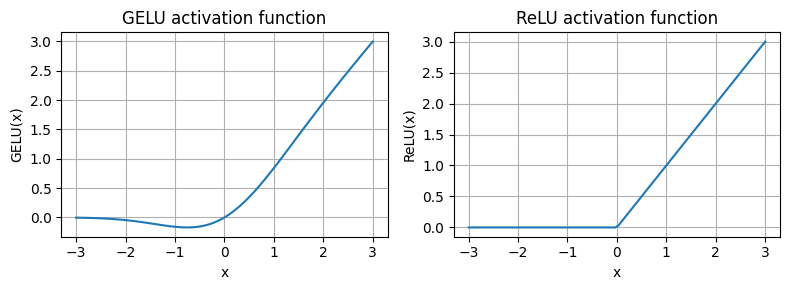

In [14]:
# 创建GELU类的实例，用于后续计算GELU激活函数的输出
gelu, relu = GELU(), nn.ReLU()
# 生成一些示例数据，通过torch.linspace创建一个从-3到3均匀分布的一维张量，包含100个数据点
# 这个张量将作为输入传递给激活函数来生成对应的输出
x = torch.linspace(-3, 3, 100)
# 分别将生成的示例数据x传入gelu和relu实例的forward方法（通过调用实例本身的方式，如gelu(x)）
# 得到经过GELU激活函数和ReLU激活函数处理后的输出结果y_gelu和y_relu
y_gelu, y_relu = gelu(x), relu(x)
# 创建一个新的图形对象，设置图形的大小为宽8单位、高3单位
plt.figure(figsize=(8, 3))
# 使用enumerate函数同时遍历两个列表（[y_gelu, y_relu]和["GELU", "ReLU"]）
# i是索引值，从1开始；(y, label)是对应列表中的元素对，y是激活函数的输出，label是对应的激活函数名称
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    # 在1行2列的子图布局中，选择第i个子图进行绘制操作
    plt.subplot(1, 2, i)
    # 在当前子图中绘制输入数据x和对应的激活函数输出y的关系曲线
    plt.plot(x, y)
    # 设置当前子图的标题，格式为"{激活函数名称} activation function"
    plt.title(f"{label} activation function")
    # 设置当前子图的x轴标签为"x"
    plt.xlabel("x")
    # 设置当前子图的y轴标签为"{激活函数名称}(x)"
    plt.ylabel(f"{label}(x)")
    # 在当前子图中显示网格线，以便更清晰地观察曲线
    plt.grid(True)
# 自动调整子图的布局，使它们之间的间距更加合理，避免图形元素相互重叠
plt.tight_layout()
# 显示绘制好的图形
plt.show()

- As we can see, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero
- GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values (except at approximately -0.75)

- Next, let's implement the small neural network module, `FeedForward`, that we will be using in the LLM's transformer block later:

In [15]:
import torch
import torch.nn as nn
# 定义一个名为FeedForward的类，它继承自nn.Module，用于实现前馈神经网络模块
class FeedForward(nn.Module):
    def __init__(self, cfg):
        """
        类的初始化方法
        Args:
            cfg (dict): 一个配置字典，包含了构建前馈神经网络所需的参数信息，比如嵌入维度等
        """
        super().__init__()
        # 使用nn.Sequential容器来按顺序组合多个神经网络层，形成一个前馈神经网络的结构
        self.layers = nn.Sequential(
            # 定义第一个全连接层，输入维度为配置字典中指定的嵌入维度cfg["emb_dim"]，输出维度为嵌入维度的4倍
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            # 实例化GELU激活函数类，用于在第一个全连接层之后添加非线性变换
            GELU(),
            # 定义第二个全连接层，输入维度为第一个全连接层输出的4倍cfg["emb_dim"]，输出维度为配置字典中指定的嵌入维度cfg["emb_dim"]
            # 这样就实现了将输入维度经过中间的变换后又恢复到原始的嵌入维度
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
    def forward(self, x):
        """
        前向传播方法，用于执行前馈神经网络的计算
        Args:
            x (torch.Tensor): 输入的张量，其维度应该与配置字典中指定的嵌入维度相匹配，例如形状可能是(batch_size, emb_dim)等
        Returns:
            torch.Tensor: 经过前馈神经网络处理后的输出张量，其维度与输入张量x的维度相同（除了可能经过非线性变换后的数值变化）
        """
        return self.layers(x)

In [16]:
# 通过字典的键"emb_dim"来获取对应的值，也就是获取GPT模型在124M配置下的嵌入维度的值，并将其打印出来
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">

In [17]:
# 创建一个FeedForward类的实例ffn，将GPT_CONFIG_124M作为参数传递给构造函数
# FeedForward类会根据GPT_CONFIG_124M中的配置信息（例如嵌入维度等相关参数）来初始化其内部的神经网络层结构
ffn = FeedForward(GPT_CONFIG_124M)
# 生成一个形状为[batch_size, num_token, emb_size]的随机张量x
# 这里指定batch_size为2，表示有两批数据；num_token为3，可理解为每个批次中有3个“标记”（具体含义取决于应用场景）；emb_size为768，即嵌入维度为768
# 这个随机张量x将作为输入传递给前面创建的ffn实例，用于在其内部的前馈神经网络中进行处理
x = torch.rand(2, 3, 768)
# 将生成的随机输入张量x传递给ffn实例的forward方法进行处理
# 也就是让x通过ffn内部构建的前馈神经网络结构（包含线性层、激活函数等）进行计算，得到经过该网络处理后的输出结果out
out = ffn(x)
# 打印输出结果out的形状，通过查看形状可以了解经过ffn前馈神经网络处理后，张量的维度是否发生了变化以及具体的维度情况
# 这有助于我们进一步分析数据在网络中的流动和处理效果
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="400px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="400px">

## 4.4 Adding shortcut connections

- Next, let's talk about the concept behind shortcut connections, also called skip or residual connections
- Originally, shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems
- A shortcut connection creates an alternative shorter path for the gradient to flow through the network
- This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between
- Let's illustrate this idea with a small example network:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

- In code, it looks like this:

In [18]:
# 定义一个名为ExampleDeepNeuralNetwork的类，它继承自nn.Module，用于构建一个示例的深度神经网络
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        """
        类的初始化方法
        Args:
            layer_sizes (list): 一个包含整数的列表，指定了神经网络各层的输入和输出维度大小。
            例如，[input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size]
            use_shortcut (bool): 一个布尔值，用于决定是否在网络中使用shortcut连接（残差连接）。
        """
        super().__init__()
        self.use_shortcut = use_shortcut
        # 使用nn.ModuleList来存储神经网络的各个层，每个层由一个nn.Sequential容器组成，
        # 其中包含一个线性层（nn.Linear）和一个GELU激活函数（GELU）
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layers_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])
    def forward(self, x):
        """
        前向传播方法，用于执行深度神经网络的计算
        Args:
            x (torch.Tensor): 输入的张量，其维度应该与layer_sizes[0]指定的输入维度相匹配。
        Returns:
            torch.Tensor: 经过深度神经网络处理后的输出张量。
        """
        for layer in self.layers:
            # 计算当前层的输出
            layer_output = layer(x)
            # 检查是否可以应用shortcut连接（残差连接）
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output

        return x
def print_gradients(model, x):
    """
    该函数用于计算并打印给定模型在输入数据x下的权重梯度的均值绝对值。
    Args:
        model (nn.Module): 一个已经定义好的神经网络模型，例如ExampleDeepNeuralNetwork的实例。
        x (torch.Tensor): 输入的张量，其维度应该与模型的输入维度要求相匹配。
    """
    # 前向传播
    output = model(x)
    # 定义目标张量，这里简单地设置为一个值为0的二维张量，形状为[[0.]]
    target = torch.tensor([[0.]])
    # 根据输出和目标之间的接近程度计算损失，这里使用均方误差损失函数（MSELoss）
    loss = nn.MSELoss()
    loss = loss(output, target)
    # 进行反向传播，以计算模型参数的梯度
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            # 打印权重的平均绝对梯度，通过取梯度的绝对值并计算其均值，再获取其具体的值（item()）来实现
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- Let's print the gradient values first **without** shortcut connections:

In [19]:
layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- Next, let's print the gradient values **with** shortcut connections:

In [20]:
import torch
import torch.nn as nn
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
# 设置随机种子为123，以便在后续涉及随机操作（如模型参数初始化等）时能复现结果
torch.manual_seed(123)
# 创建一个ExampleDeepNeuralNetwork类的实例，传入layer_sizes列表和use_shortcut=False
# 表示创建一个不使用shortcut连接（残差连接）的深度神经网络模型
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
# 调用print_gradients函数，传入创建好的不使用shortcut连接的模型实例和示例输入张量
# 该函数会进行前向传播、计算损失、反向传播并打印出模型权重参数的平均绝对梯度
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


    - As we can see based on the output above, shortcut connections prevent the gradients from vanishing in the early layers (towards `layer.0`)
    - We will use this concept of a shortcut connection next when we implement a transformer block

## 4.5 Connecting attention and linear layers in a transformer block

- In this section, we now combine the previous concepts into a so-called transformer block
- A transformer block combines the causal multi-head attention module from the previous chapter with the linear layers, the feed forward neural network we implemented in an earlier section
- In addition, the transformer block also uses dropout and shortcut connections

In [21]:
from previous_chapters import MultiHeadAttention
import torch
import torch.nn as nn
# 定义一个名为TransformerBlock的类，它继承自nn.Module，用于构建Transformer模块
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        """
        类的初始化方法
        Args:
            cfg (dict): 一个配置字典，包含了构建Transformer模块所需的各种参数，如嵌入维度、上下文长度、头的数量、丢弃率、查询-键-值偏差等。
        """
        super().__init__()
        # 创建一个MultiHeadAttention实例，用于实现多头注意力机制
        # 根据配置字典cfg中的参数来初始化多头注意力机制的输入维度（d_in）、输出维度（d_out）、上下文长度（context_length）、
        # 头的数量（num_heads）、丢弃率（dropout）和查询-键-值偏差（qkv_bias）等属性
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        # 创建一个FeedForward实例，用于实现前馈神经网络
        # 根据配置字典cfg中的参数来初始化前馈神经网络的相关参数，如嵌入维度等
        self.ff = FeedForward(cfg)
        # 创建一个LayerNorm实例，用于对输入进行层归一化操作
        # 根据配置字典cfg中的参数来初始化层归一化的嵌入维度
        self.norm1 = LayerNorm(cfg["emb_dim"])
        # 创建另一个LayerNorm实例，用于对输入进行层归一化操作
        # 根据配置字典cfg中的参数来初始化层归一化的嵌入维度
        self.norm2 = LayerNorm(cfg["emb_dim"])
        # 创建一个Dropout实例，用于在训练过程中以一定的丢弃率随机丢弃一些神经元的输出，防止过拟合
        # 根据配置字典cfg中的参数来初始化丢弃率
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
        """
        前向传播方法，用于执行Transformer模块的计算
        Args:
            x (torch.Tensor): 输入的张量，其形状通常为[batch_size, num_tokens, emb_size]，其中batch_size表示批次大小，
            num_tokens表示每个批次中的标记数量，emb_size表示嵌入维度。
        Returns:
            torch.Tensor: 经过Transformer模块处理后的输出张量，其形状与输入张量x相同。
        """
        # 保存输入张量x作为shortcut连接（残差连接）的原始输入，以便后续添加回来
        shortcut = x
        # 对输入张量x进行层归一化操作，使用self.norm1实例进行层归一化
        x = self.norm1(x)
        # 将经过层归一化后的x传入self.att实例（即多头注意力机制）进行处理，得到处理后的张量x
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        # 对经过多头注意力机制处理后的x应用Dropout操作，以一定的丢弃率随机丢弃一些神经元的输出
        x = self.drop_shortcut(x)
        # 将经过Dropout操作后的x与原始输入shortcut相加，实现shortcut连接（残差连接），得到更新后的x
        x = x + shortcut  # Add the original input back
        # 再次保存当前的x作为下一个shortcut连接（残差连接）的原始输入，以便后续添加回来
        shortcut = x
        # 对当前的x进行层归一化操作，使用self.norm2实例进行层归一化
        x = self.norm2(x)
        # 将经过层归一化后的x传入self.ff实例（即前馈神经网络）进行处理，得到处理后的张量x
        x = self.ff(x)
        # 对经过前馈神经网络处理后的x应用Dropout操作，以一定的丢弃率随机丢弃一些神经元的输出
        x = self.drop_shortcut(x)
        # 将经过Dropout操作后的x与原始输入shortcut相加，实现shortcut连接（残差连接），得到最终更新后的x
        x = x + shortcut  # Add the original input back
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

- Suppose we have 2 input samples with 6 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size
- You can think of the output as an augmented version of the context vectors we discussed in the previous chapter

In [22]:
torch.manual_seed(123)
# 生成一个形状为[batch_size, num_tokens, emb_dim]的随机张量x
# 其中batch_size为2，表示有两批数据；num_tokens为4，表示每批数据中有4个“标记”（具体含义取决于应用场景）；emb_dim为768，表示嵌入维度为768
x = torch.rand(2, 4, 768)  
# 创建一个TransformerBlock类的实例block，传入GPT_CONFIG_124M作为配置参数
# 该实例将根据GPT_CONFIG_124M中的配置信息来构建内部的多头注意力机制、前馈神经网络等组件
block = TransformerBlock(GPT_CONFIG_124M)
# 将生成的随机张量x传入block实例的forward方法（通过调用block(x)）进行处理
# 得到经过TransformerBlock模块处理后的输出结果output
output = block(x)
# 打印输入张量x的形状，以便查看原始输入数据的维度情况
print("Input shape:", x.shape)
# 打印输出结果output的形状，通过对比输入和输出的形状，可以了解数据在经过TransformerBlock模块处理后维度是否发生变化以及具体的变化情况
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">

## 4.6 Coding the GPT model

- We are almost there: now let's plug in the transformer block into the architecture we coded at the very beginning of this chapter so that we obtain a usable GPT architecture
- Note that the transformer block is repeated multiple times; in the case of the smallest 124M GPT-2 model, we repeat it 12 times:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">

- The corresponding code implementation, where `cfg["n_layers"] = 12`:

In [23]:
# 定义一个名为GPTModel的类，它继承自nn.Module，用于构建GPT模型
class GPTModel(nn.Module):
    def __init__(self, cfg):
        """
        类的初始化方法
        Args:
            cfg (dict): 一个配置字典，包含了构建GPT模型所需的各种参数，如词汇表大小、嵌入维度、上下文长度、层数、丢弃率等。
        """
        super().__init__()
        # 创建一个词嵌入层（nn.Embedding），用于将输入的词汇索引转换为对应的嵌入向量
        # 根据配置字典cfg中的词汇表大小（vocab_size）和嵌入维度（emb_dim）来初始化词嵌入层的参数
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # 创建一个位置嵌入层（nn.Embedding），用于为每个位置生成对应的嵌入向量
        # 根据配置字典cfg中的上下文长度（context_length）和嵌入维度（emb_dim）来初始化位置嵌入层的参数
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # 创建一个Dropout实例，用于在训练过程中以一定的丢弃率随机丢弃一些神经元的输出，防止过拟合
        # 根据配置字典cfg中的丢弃率（drop_rate）来初始化Dropout的参数
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        # 使用nn.Sequential容器和列表推导式创建一个包含多个TransformerBlock实例的序列
        # 根据配置字典cfg中的层数（n_layers）来确定创建的TransformerBlock实例的数量
        # 每个TransformerBlock实例都将根据cfg中的配置信息来构建内部的多头注意力机制、前馈神经网络等组件
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        # 创建一个LayerNorm实例，用于对输入进行层归一化操作
        # 根据配置字典cfg中的嵌入维度（emb_dim）来初始化层归一化的参数
        self.final_norm = LayerNorm(cfg["emph_dim"])
        # 创建一个线性输出层（nn.Linear），用于将经过处理后的嵌入向量转换为词汇表大小维度的输出向量，以便预测下一个词汇
        # 根据配置字典cfg中的嵌入维度（emb_dim）和词汇表大小（vocab_size）来初始化线性输出层的参数，并且设置偏差为False
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    def forward(self, in_idx):
        """
        前向传播方法，用于执行GPT模型的计算
        Args:
            in_idx (int): 输入的词汇索引张量，其形状通常为[batch_size, seq_len]，其中batch_size表示批次大小，
            seq_len表示序列长度。
        Returns:
            torch.Tensor: 经过GPT模型处理后的输出张量，其形状通常为[batch_size, seq_len, vocab_size]，用于预测下一个词汇的概率分布。
        """
        batch_size, seq_len = in_idx.shape
        # 将输入的词汇索引张量in_idx传入词嵌入层self.tok_emb进行处理，得到对应的词嵌入向量tok_embeds
        tok_embeds = self.tok_emb(in_idx)
        # 使用torch.arange生成一个从0到seq_len - 1的张量，作为位置索引，并将其传入位置嵌入层self.pos_emb进行处理，得到对应的位置嵌入向量pos_embeds
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # 将词嵌入向量tok_embeds和位置嵌入向量pos_embeds相加，得到组合后的嵌入向量x，其形状为[batch_size, num_tokens, emb_size]
        x = tok_embeds + pos_embeds  
        # 对组合后的嵌入向量x应用Dropout操作，以一定的丢弃率随机丢弃一些神经元的输出
        x = self.drop_emb(x)
        # 将经过Dropout操作后的x传入由多个TransformerBlock实例组成的序列self.trf_blocks进行处理，得到处理后的向量x
        x = self.trf_blocks(x)
        # 对经过TransformerBlock序列处理后的x应用层归一化操作，使用self.final_norm实例进行层归一化
        x = self.final_norm(x)
        # 将经过层归一化后的x传入线性输出层self.out_head进行处理，得到预测下一个词汇的输出向量logits
        logits = self.out_head(x)
        return logits

- Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights as follows:

In [24]:
torch.manual_seed(123)
# 创建一个GPTModel类的实例model，传入GPT_CONFIG_124M作为配置参数
# 该实例将根据GPT_CONFIG_124M中的配置信息来构建内部的词嵌入层、位置嵌入层、TransformerBlock等组件，从而形成一个完整的GPT模型
model = GPTModel(GPT_CONFIG_124M)
# 将输入的batch数据传入model实例的forward方法（通过调用model(batch)）进行处理
# 得到经过GPT模型处理后的输出结果out
out = model(batch)
# 打印输入的batch数据，以便查看原始输入数据的内容
print("Input batch:\n", batch)
# 打印输出结果out的形状，通过对比输入batch的形状和输出的形状，可以了解数据在经过GPT模型处理后维度是否发生变化以及具体的变化情况
print("\nOutput shape:", out.shape)
# 打印输出结果out的具体内容，以便进一步查看经过GPT模型处理后得到的数据情况
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- We will train this model in the next chapter
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [25]:
# 计算模型model中所有可学习参数的总数。这里通过遍历模型的所有参数（model.parameters()），
# 对于每个参数p，使用numel()方法获取其元素个数（即参数的数量），然后将所有参数的数量相加
total_params = sum(p.numel() for p in model.parameters())
# 打印出模型的总参数数量，使用格式化字符串将数字按照千分位分隔的形式进行输出，以便更清晰地查看较大的数字
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- As we see above, this model has 163M, not 124M parameters; why?
- In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (`tok_emb`) as the output layer, which means setting `self.out_head.weight = self.tok_emb.weight`
- The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
- The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words (more about that in the next section)
- So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [26]:
# 打印词嵌入层（token embedding layer）的权重形状。
# 模型中的model.tok_emb是一个nn.Embedding实例，其weight属性存储着词嵌入层的权重张量。
# 通过访问该权重张量的形状，可以了解到词嵌入层中权重矩阵的维度信息，
print("Token embedding layer shape:", model.tok_emb.weight.shape)
# 打印输出层（output layer）的权重形状。
# 模型中的model.out_head是一个nn.Linear实例，其weight属性存储着输出层的权重张量。
# 通过访问该权重张量的形状，可以了解到输出层中权重矩阵的维度信息，
# 比如输入维度（这里通常是嵌入维度）和输出维度（这里通常是词汇表大小）等相关情况。
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- In the original GPT-2 paper, the researchers reused the token embedding matrix as an output matrix
- Correspondingly, if we subtracted the number of parameters of the output layer, we'd get a 124M parameter model:

In [27]:
# 计算考虑权重绑定（weight tying）后的可训练参数数量。
# 在原始的GPT-2中存在将词嵌入矩阵复用为输出矩阵的情况（即权重绑定），这里通过先获取模型的总参数数量（total_params），
# 然后减去输出层（model.out_head）的所有参数数量（通过遍历输出层的参数并累加其元素个数，即sum(p.numel() for p in model.out_head.parameters())），
# 得到的结果就是考虑了权重绑定后的可训练参数数量，记为total_params_gpt2。
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
# 打印出考虑权重绑定后的可训练参数数量，使用格式化字符串将数字按照千分位分隔的形式进行输出，以便更清晰地查看较大的数字。
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- In practice, I found it easier to train the model without weight-tying, which is why we didn't implement it here
- However, we will revisit and apply this weight-tying idea later when we load the pretrained weights in chapter 5
- Lastly, we can compute the memory requirements of the model as follows, which can be a helpful reference point:

In [28]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
# 计算模型参数的总大小（以字节为单位）。这里假设模型的参数数据类型为float32，
# 而float32类型的每个参数占用4字节的存储空间。所以通过将模型的总参数数量（total_params）
# 乘以每个参数占用的字节数（4），就可以得到模型参数的总字节数（total_size_bytes）。
total_size_bytes = total_params * 4
# Convert to megabytes
# 将总字节数转换为兆字节（MB）。因为1兆字节等于1024 * 1024字节，所以通过将总字节数（total_size_bytes）
# 除以1024 * 1024，就可以得到以兆字节为单位的模型大小（total_size_mb）。
total_size_mb = total_size_bytes / (1024 * 1024)
# 打印出模型的总大小，以兆字节为单位，并保留两位小数，以便更清晰、准确地展示模型的大小信息。
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- Exercise: you can try the following other configurations, which are referenced in the [GPT-2 paper](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C), as well.

    - **GPT2-small** (the 124M configuration we already implemented):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 Generating text

- LLMs like the GPT model we implemented above are used to generate one word at a time

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">

- The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
- In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
- In the next chapter, we will implement a more advanced `generate_text` function
- The figure below depicts how the GPT model, given an input context, generates the next word token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

In [29]:
import torch


def generate_text_simple(model, idx, max_new_tokens, context_size):
    """
    简单生成文本的函数。
    该函数基于给定的模型，根据当前上下文索引逐步生成新的文本标记，直到达到指定的新标记生成数量。
    Args:
        model (nn.Module): 已经训练好的模型，例如GPT相关模型等，用于根据输入的上下文生成预测结果。
        idx (torch.Tensor): 当前上下文的索引张量，形状为(batch, n_tokens)，其中batch表示批次大小，n_tokens表示当前上下文中的标记数量，
                           这些索引对应着词汇表中的词汇。
        max_new_tokens (int): 要生成的新标记的最大数量，即生成文本的长度限制。
        context_size (int): 模型所支持的上下文大小，用于确定在生成过程中实际使用多少个先前的标记作为上下文。
    Returns:
        torch.Tensor: 返回一个形状为(batch, n_tokens + max_new_tokens)的张量，包含了原始的上下文索引以及生成的新标记索引，
                      后续可根据该索引张量转换为实际的文本内容。
    """
    # idx是当前上下文中索引的(batch, n_tokens)数组
    for _ in range(max_new_tokens):
        # 如果当前上下文的标记数量超过了模型支持的上下文大小，就对当前上下文进行裁剪
        # 例如，如果语言模型（LLM）只支持5个标记的上下文，而当前上下文大小是10，那么就只使用最后5个标记作为上下文
        idx_cond = idx[:, -context_size:]
        # 获取预测结果
        with torch.no_grad():  # 在不计算梯度的情况下，因为这里只是生成文本，不需要进行反向传播来更新模型参数
            logits = model(idx_cond)
        # 只聚焦于最后一个时间步的预测结果
        # 原本形状为(batch, n_tokens, vocab_size)的预测结果，经过这一步变为(batch, vocab_size)
        logits = logits[:, -1, :]
        # 应用softmax函数来获取每个词汇的概率分布
        probas = torch.softmax(logits, dim=-1)  # 得到的概率分布形状为(batch, vocab_size)
        # 获取词汇表中具有最高概率值的词汇的索引
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # 得到的索引形状为(batch, 1)
        # 将采样得到的索引追加到正在生成的序列后面
        idx = torch.cat((idx, idx_next), dim=1)  # 追加后的idx形状变为(batch, n_tokens + 1)
    return idx

- The `generate_text_simple` above implements an iterative process, where it creates one token at a time

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

- Let's prepare an input example:

In [30]:
# 定义起始上下文文本
start_context = "Hello, I am"
# 使用分词器对起始上下文文本进行编码操作，将文本转换为对应的编码形式（通常是一系列的整数索引，对应词汇表中的词汇）
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
# 将编码后的结果转换为PyTorch张量，并在第0维上增加一个维度，使其形状变为 (1, n) 的形式，其中n是编码后的长度
# 这样做通常是为了使其符合模型输入的批次维度要求
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [31]:
# 将模型设置为评估模式，在评估模式下，模型中的Dropout层等随机操作会被禁用，以保证模型输出的一致性和可重复性
model.eval()  
# 调用generate_text_simple函数来生成文本，传入以下参数：
# - model：已经训练好的模型实例，这里就是前面定义的用于生成文本的模型（如GPT相关模型）
# - idx：作为起始上下文的编码张量，形状为 (1, n)，这里的n是起始上下文经过分词器编码后的长度，它作为生成文本的初始输入
# - max_new_tokens：要生成的新标记的最大数量，这里设置为6，表示在起始上下文的基础上再生成6个新的标记来组成一段更长的文本
# - context_size：模型所支持的上下文长度，这里使用GPT_CONFIG_124M配置字典中的"context_length"值作为上下文长度，它决定了在生成过程中模型能参考的先前标记的数量
out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)
# 打印生成文本的输出结果，这里的输出结果是一个张量，包含了起始上下文的编码以及生成的新标记的编码
print("Output:", out)
# 打印生成文本的输出结果的长度，这里是取输出结果张量中第一个元素（因为批次大小为1）的长度，也就是整个输出的编码长度，
# 它等于起始上下文编码长度加上生成的新标记的数量
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- Remove batch dimension and convert back into text:

In [32]:
# 使用分词器对生成文本的输出结果进行解码操作。
# 首先，通过out.squeeze(0)将输出结果张量的第0维（批次维度，因为批次大小为1，所以可以去除这一维）进行压缩，得到一个一维张量。
# 然后，通过tolist()方法将这个一维张量转换为Python列表形式。
# 最后，将这个列表形式的编码传递给tokenizer.decode()方法，将其解码为人类可读的文本形式，得到的结果存储在decoded_text变量中。
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
# 打印出解码后的文本内容，以便查看通过模型生成并经过解码后的最终文本呈现效果。
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- Note that the model is untrained; hence the random output texts above
- We will train the model in the next chapter

## Summary and takeaways

- See the [./gpt.py](./gpt.py) script, a self-contained script containing the GPT model we implement in this Jupyter notebook
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)